In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
train=pd.read_csv("./churn_prediction_data/train.csv")
test=pd.read_csv("./churn_prediction_data/test.csv")

In [3]:
train["Exited"].value_counts()

0    6368
1    1632
Name: Exited, dtype: int64

## 資料前處理

In [4]:
#ID取前四個數字
train["ID"]=train['CustomerId'].astype(str).str[:5].astype(int)
#將財務商品整合成兩類，大於2個、少於等於2個
train["is_4"]=train['NumOfProducts'].apply(lambda x: 1 if x >2  else 0)
#性別數值化(男生0、女生1)
train['Gender']=train['Gender'].apply(lambda x: 1 if x =="male"  else 0)
train["greater than 70000"]=train["Balance"].apply(lambda x: 1 if x >70000  else 0)

In [5]:
#將名字數值化
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['Surname'].append(test['Surname']))
train["NAME_ID"]=pd.Series(le.transform(train['Surname']))

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train[["Balance","EstimatedSalary"]])
#train["money"] = pca.transform(train[["Balance","EstimatedSalary"]])

PCA(n_components=2)

In [7]:
moneys=pd.DataFrame(pca.transform(train[["Balance","EstimatedSalary"]]),columns=['money1', 'money2'])

In [8]:
#選擇重要的特徵
select_data=train[["CreditScore","Tenure","Gender","IsActiveMember",'Age','NumOfProducts']]

In [9]:
#國家dummy variable
features_dummies=pd.get_dummies(train["Geography"])

In [10]:
#合併資料
#data=select_data
data=pd.concat([select_data, features_dummies,moneys],axis=1)

In [11]:
data

,CreditScore,Tenure,Gender,IsActiveMember,Age,NumOfProducts,France,Germany,Spain,money1,money2
0,720,5,0,1,38,2,0,0,1,13784.383558,-6901.467300
1,682,4,0,0,54,1,1,0,0,-37593.455871,-14575.170599
2,672,5,0,1,31,1,1,0,0,20694.439982,-31981.509836
3,592,4,0,0,40,1,0,0,1,4136.517003,-10589.545937
4,753,5,0,1,42,1,0,0,1,20903.401084,-25420.365050
...,...,...,...,...,...,...,...,...,...,...,...
7995,568,6,0,1,35,2,1,0,0,21532.227588,-23904.576921
7996,602,7,0,0,45,1,0,1,0,45202.194321,2726.463178
7997,679,5,0,0,43,1,0,0,1,33499.446898,-29297.572738
7998,715,4,0,0,38,1,1,0,0,17950.374014,5376.905107


## 切訓練集/測試集

In [12]:
#切割資料
train_data,test_data,train_labels,test_labels=train_test_split(data,train["Exited"],test_size=0.01)

In [13]:
train_labels = np.array(train_labels)
train_data =  np.array(train_data)
test_labels= np.array(test_labels)
test_data = np.array(test_data)

## 處理資料不平衡

In [14]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
train_data, train_labels = sm.fit_resample(train_data, train_labels)

## model1：KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(train_data,train_labels)

KNeighborsClassifier()

In [16]:
knn.score(train_data,train_labels)

0.8039200126963973

In [17]:
knn.score(test_data,test_labels)

0.5375

<Figure size 432x288 with 0 Axes>

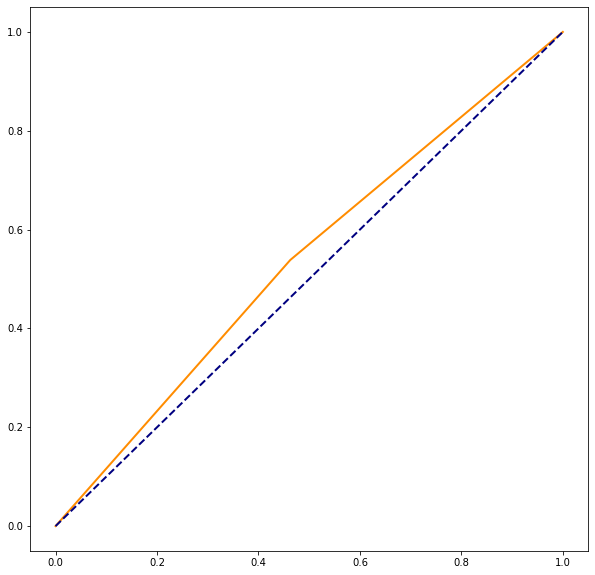

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, knn.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [19]:
roc_auc

0.5378874856486796

## model2：Decision tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(criterion='entropy') 
dt.fit(train_data,train_labels) 

DecisionTreeClassifier(criterion='entropy')

In [21]:
dt.score(train_data,train_labels)

1.0

In [22]:
dt.score(test_data,test_labels)

0.8125

<Figure size 432x288 with 0 Axes>

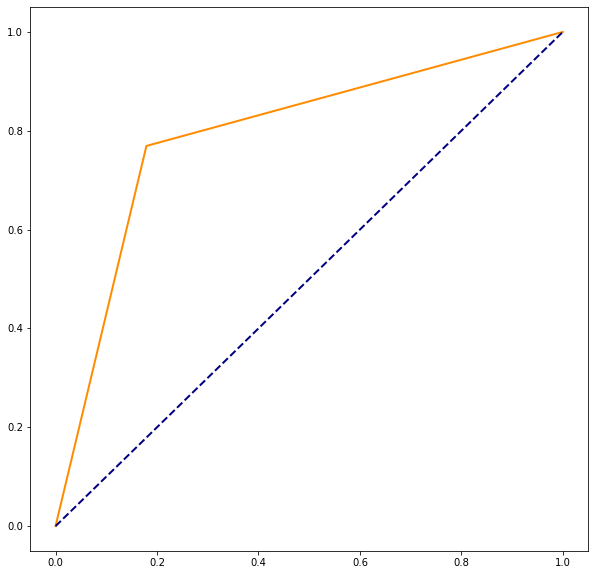

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, dt.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [24]:
roc_auc

0.7950631458094145

## model3：Random forest

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import  ensemble, preprocessing, metrics
forest = ensemble.RandomForestClassifier(max_depth=10,n_estimators=32)
forest.fit(train_data,train_labels)

RandomForestClassifier(max_depth=10, n_estimators=32)

In [27]:
forest.score(train_data,train_labels)

0.9196952864624662

In [28]:
forest.score(test_data,test_labels)

0.8625

<Figure size 432x288 with 0 Axes>

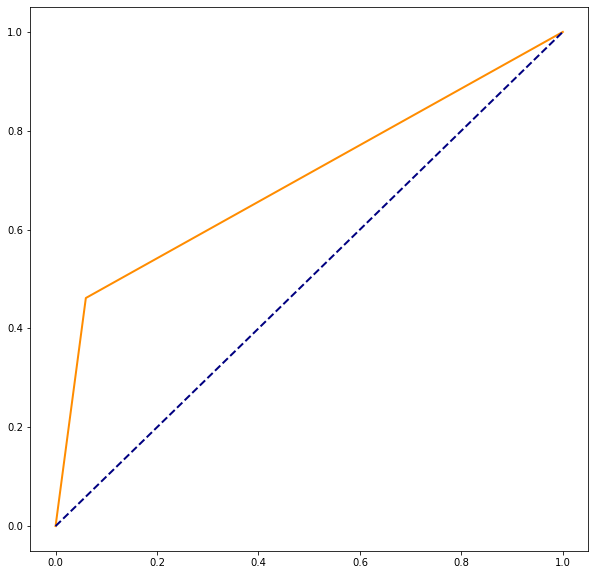

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, forest.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [30]:
roc_auc

0.7009184845005741

In [31]:
data.columns

Index(['CreditScore', 'Tenure', 'Gender', 'IsActiveMember', 'Age',
       'NumOfProducts', 'France', 'Germany', 'Spain', 'money1', 'money2'],
      dtype='object')

In [32]:
forest.feature_importances_

array([0.02243064, 0.03197538, 0.        , 0.20565482, 0.22501201,
       0.22350177, 0.07880445, 0.08719518, 0.04198187, 0.0593259 ,
       0.02411798])

## model4：LogisticRegression

In [33]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression(solver="lbfgs")
lm.fit(train_data, train_labels)

LogisticRegression()

In [34]:
lm.score(train_data,train_labels)

0.69687351214093

In [35]:
lm.score(test_data,test_labels)

0.525

In [36]:
lm.coef_

array([[-4.42634270e-03, -3.13162728e-01,  0.00000000e+00,
        -4.63205601e-01,  1.06368431e-01, -1.44777498e-01,
        -2.20354840e-01,  2.15751955e-01, -4.65779158e-02,
         7.78443561e-06, -8.95275458e-07]])

In [37]:
data.columns

Index(['CreditScore', 'Tenure', 'Gender', 'IsActiveMember', 'Age',
       'NumOfProducts', 'France', 'Germany', 'Spain', 'money1', 'money2'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

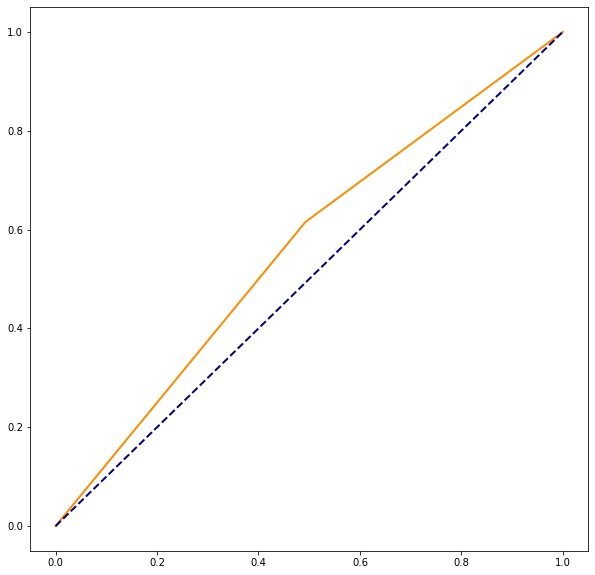

In [38]:
#畫ROC圖表
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, lm.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [39]:
roc_auc

0.5614236509758899

## model5：LightGBM

In [40]:
import lightgbm as lgb
LGB=lgb.LGBMClassifier()
LGB.fit(train_data,train_labels)

LGBMClassifier()

In [41]:
LGB.score(train_data,train_labels)

0.9367560704650055

In [42]:
LGB.score(test_data,test_labels)

0.9125

<Figure size 432x288 with 0 Axes>

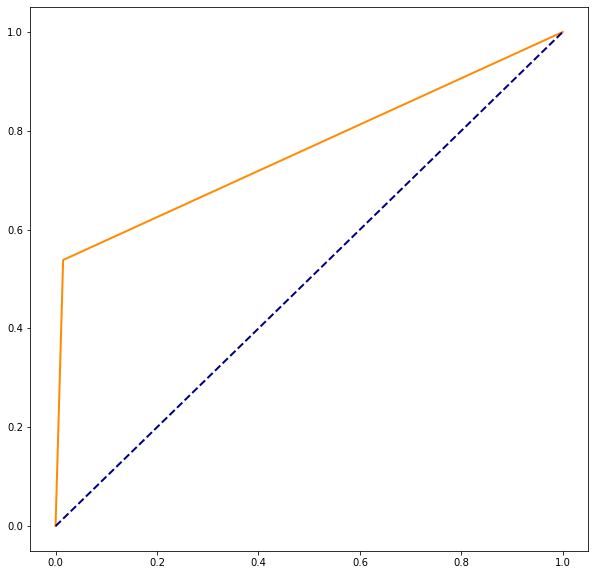

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, LGB.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [44]:
roc_auc

0.761768082663605

## model6：GradientBoostingClassifier

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(train_data,train_labels)

GradientBoostingClassifier()

In [46]:
gbc.score(train_data,train_labels)

0.9130296778289161

In [47]:
gbc.score(test_data,test_labels)

0.925

<Figure size 432x288 with 0 Axes>

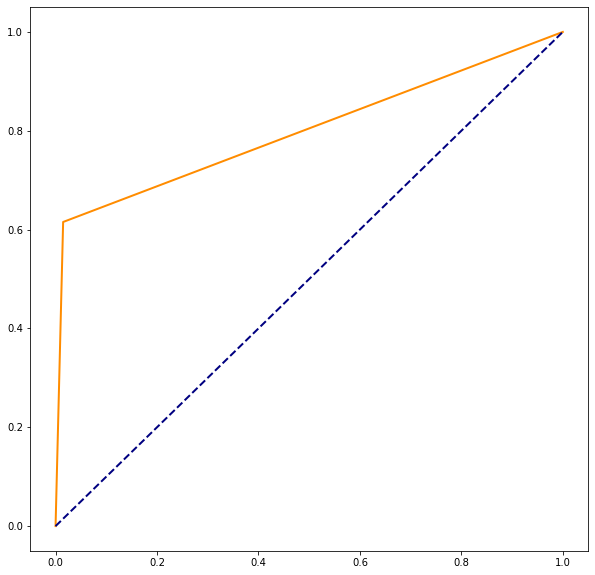

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, gbc.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [49]:
roc_auc

0.8002296211251435

## model7：XGBClassifier

In [50]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier()
xgb.fit(train_data,train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
xgb.score(train_data,train_labels)

0.9620695127757499

In [52]:
xgb.score(test_data,test_labels)

0.9

<Figure size 432x288 with 0 Axes>

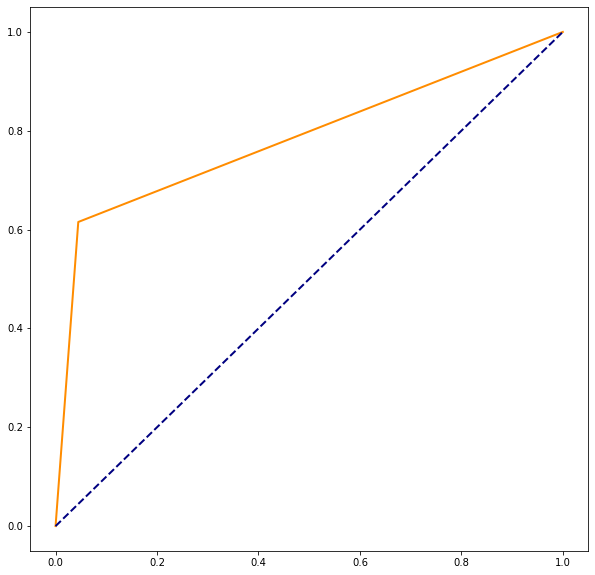

In [53]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, xgb.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [54]:
roc_auc

0.7853042479908151

In [102]:
from sklearn.model_selection import KFold,StratifiedKFold,ShuffleSplit
cv=StratifiedKFold(n_splits=10)
#cv=KFold(n_splits=5)
#cv2=ShuffleSplit(n_splits=5,test_size=0.1)

In [103]:
from sklearn.model_selection import cross_val_score
#accuracy
scores1 =cross_val_score(knn,data,train["Exited"],cv=cv,scoring='accuracy').mean()
scores2 =cross_val_score(dt,data,train["Exited"],cv=cv,scoring='accuracy').mean()
scores3 =cross_val_score(forest,data,train["Exited"],cv=cv,scoring='accuracy').mean()
scores4 =cross_val_score(lm,data,train["Exited"],cv=cv,scoring='accuracy').mean()
scores5 =cross_val_score(LGB,data,train["Exited"],cv=cv,scoring='accuracy').mean()
scores6 =cross_val_score(gbc,data,train["Exited"],cv=cv,scoring='accuracy').mean()
scores7 =cross_val_score(xgb,data,train["Exited"],cv=cv,scoring='accuracy').mean()
accuracy=[scores1,scores2,scores3,scores4,scores5,scores6,scores7]

In [104]:
#recall
scores1 =cross_val_score(knn,data,train["Exited"],cv=cv,scoring='recall').mean()
scores2 =cross_val_score(dt,data,train["Exited"],cv=cv,scoring='recall').mean()
scores3 =cross_val_score(forest,data,train["Exited"],cv=cv,scoring='recall').mean()
scores4 =cross_val_score(lm,data,train["Exited"],cv=cv,scoring='recall').mean()
scores5 =cross_val_score(LGB,data,train["Exited"],cv=cv,scoring='recall').mean()
scores6 =cross_val_score(gbc,data,train["Exited"],cv=cv,scoring='recall').mean()
scores7 =cross_val_score(xgb,data,train["Exited"],cv=cv,scoring='recall').mean()
recall=[scores1,scores2,scores3,scores4,scores5,scores6,scores7]

In [105]:
#precision
scores1 =cross_val_score(knn,data,train["Exited"],cv=cv,scoring='precision').mean()
scores2 =cross_val_score(dt,data,train["Exited"],cv=cv,scoring='precision').mean()
scores3 =cross_val_score(forest,data,train["Exited"],cv=cv,scoring='precision').mean()
scores4 =cross_val_score(lm,data,train["Exited"],cv=cv,scoring='precision').mean()
scores5 =cross_val_score(LGB,data,train["Exited"],cv=cv,scoring='precision').mean()
scores6 =cross_val_score(gbc,data,train["Exited"],cv=cv,scoring='precision').mean()
scores7 =cross_val_score(xgb,data,train["Exited"],cv=cv,scoring='precision').mean()
precision=[scores1,scores2,scores3,scores4,scores5,scores6,scores7]

In [106]:
#roc_auc
scores1 =cross_val_score(knn,data,train["Exited"],cv=cv,scoring="roc_auc").mean()
scores2 =cross_val_score(dt,data,train["Exited"],cv=cv,scoring="roc_auc").mean()
scores3 =cross_val_score(forest,data,train["Exited"],cv=cv,scoring="roc_auc").mean()
scores4 =cross_val_score(lm,data,train["Exited"],cv=cv,scoring="roc_auc").mean()
scores5 =cross_val_score(LGB,data,train["Exited"],cv=cv,scoring="roc_auc").mean()
scores6 =cross_val_score(gbc,data,train["Exited"],cv=cv,scoring="roc_auc").mean()
scores7 =cross_val_score(xgb,data,train["Exited"],cv=cv,scoring="roc_auc").mean()
roc_auc=[scores1,scores2,scores3,scores4,scores5,scores6,scores7]

In [107]:
score=pd.DataFrame({'accuracy':accuracy,"recall":recall,"precision":precision,"roc_auc":roc_auc})
score.index=["knn","DT","forest","Logistic","LightGBM","gbc","xgb"]

In [108]:
score

,accuracy,recall,precision,roc_auc
knn,0.763000,0.087034,0.260868,0.530228
DT,0.799500,0.508570,0.498451,0.693965
forest,0.861500,0.441796,0.785673,0.854920
Logistic,0.786875,0.056371,0.360175,0.695562
LightGBM,0.863000,0.488987,0.753795,0.854145
gbc,0.863375,0.463258,0.777740,0.864155
xgb,0.854000,0.483466,0.709191,0.847016
